# EDA

In [203]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import statistics
from visualisations import compare_histograms
import random
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor

# set random seed for reproducibility
np.random.seed(42)

sns.set_theme(context='notebook', style='darkgrid', palette='Set3')

In [179]:
df = pd.read_csv('../data/clean_combined_wines.csv')
# set name column as index
df.set_index('name', inplace=True)
df.head()

,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,reviewed_by,from_vivino
name,,,,,,,,,,,,
00 Wines Vgw Chardonnay 2017,Willamette Valley,United States,2017,00 Wines,white,Chardonnay,66.0,0.0,0,13.0,"JS, WE, WS",False
00 Wines Vgr Pinot Noir 2019,Willamette Valley,United States,2019,00 Wines,red,Pinot Noir,82.0,0.0,0,12.9,"WE, JS, RP",False
00 Wines Egw Chardonnay 2019,Willamette Valley,United States,2019,00 Wines,white,Chardonnay,95.0,0.0,0,NaN,"JS, RP, WE",False
100 Nails Ranch Pinot Noir 2019,Central Coast,United States,2019,100 Nails Ranch,red,Pinot Noir,14.0,0.0,0,14.2,WW,False
100 Nails Ranch Chardonnay 2019,Sonoma County,United States,2019,100 Nails Ranch,white,Chardonnay,14.0,0.0,0,14.2,0,False


In [180]:
df.shape

(50948, 12)

In [181]:
df.describe()

,price,rating,rating_qty,abv
count,50948.000000,50948.000000,50948.000000,9906.000000
mean,44.242284,3.103164,298.227821,13.605026
std,141.390631,1.594023,791.429115,1.462862
min,2.080000,0.000000,0.000000,1.200000
25%,10.160000,3.400000,22.000000,13.000000
50%,17.960000,3.800000,81.000000,13.500000
75%,37.540000,4.000000,268.000000,14.500000
max,8215.000000,5.000000,29389.000000,21.500000


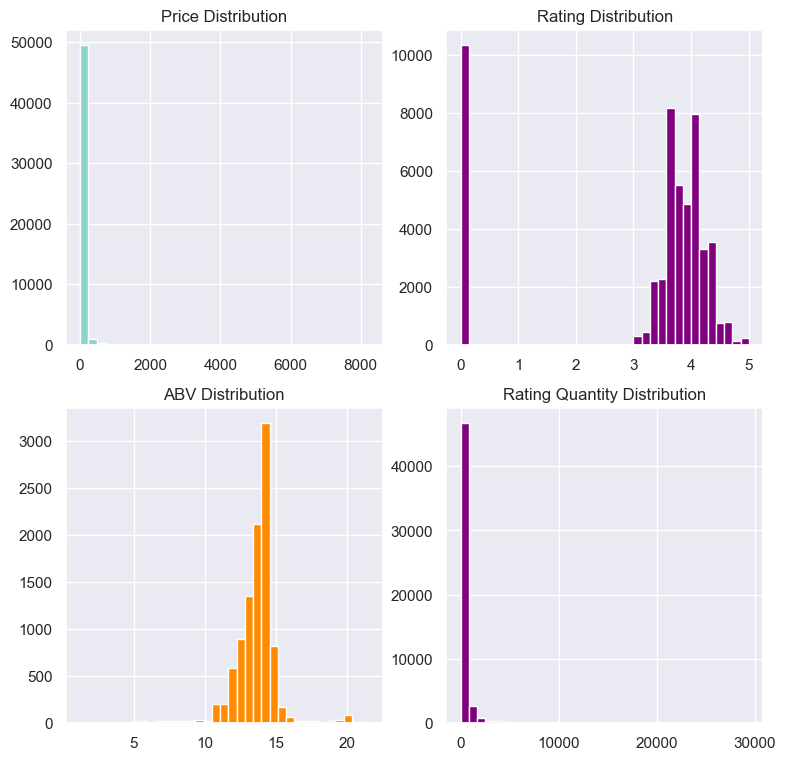

In [182]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))  # 4 subplots

# plot price
axs[0, 0].hist(df['price'], bins=35)
axs[0, 0].set_title('Price Distribution')
axs[0, 0].grid(True)

# plot rating
axs[0,1].hist(df['rating'], bins=35, color='Purple')
axs[0,1].set_title('Rating Distribution')  # Adjusted title and x label
axs[0,1].grid(True)

# plot rating_qty
axs[1, 1].hist(df['rating_qty'], bins=35, color='Purple')
axs[1, 1].set_title('Rating Quantity Distribution')  # Adjusted title and x label
axs[1, 1].grid(True)

# plot abv
axs[1, 0].hist(df['abv'], bins=35, color='DarkOrange')
axs[1, 0].set_title('ABV Distribution')  # Provided a title and x label
axs[1, 0].grid(True)

* Prices are heavily right skewed and would likely benefit from a logarithmic transformation before modelling.
* Rating qty also heavily right skewed and would likely benefit from a logarithmic transformation before modelling. Most wine have very few reviews, with some extreme outliers up to 29389. 
* ABV content fairly normally distibuted with clear spike at median of 13.5% 
- 

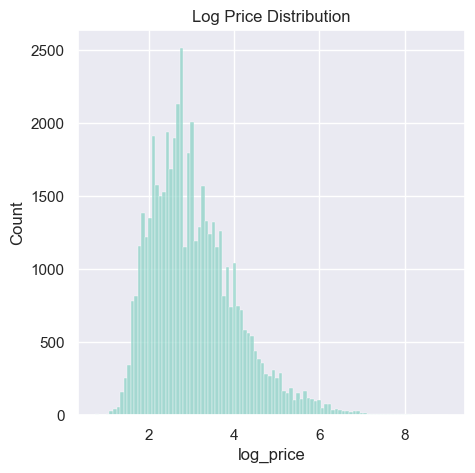

In [183]:
# remove price outliers from dataframe, log transform price and plot

df['log_price'] = np.log(df['price'])
plt.figure(figsize=(5, 5))
plt.title('Log Price Distribution')
sns.histplot(df['log_price'], bins=100)  # kde=False turns off the kernel density estimate plot overlay
plt.show();

* Log price much more normally distributed. 

Max outlier bound log_price: 5.586
Number of remaining rows: 49753, rows removed: 1195


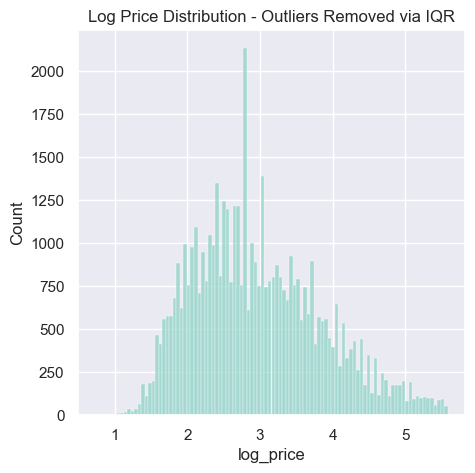

In [184]:
# calculate interquartile range of price, and set a limit at 1.5 IQR above 75% percentile
Qrt1 = np.quantile(df['log_price'], 0.25)
Qrt3 = np.quantile(df['log_price'], 0.75)
price_IQR = Qrt3 - Qrt1
outlier_price_limit = Qrt3 + (price_IQR * 1.5)
df_IQR_price = df[df['log_price'] < outlier_price_limit]
print('Max outlier bound log_price: ', round(outlier_price_limit,3), sep='')
print(f'Number of remaining rows: {df_IQR_price.shape[0]}, rows removed: {df.shape[0] - df_IQR_price.shape[0]}')
plt.figure(figsize=(5, 5))
plt.title('Log Price Distribution - Outliers Removed via IQR')
sns.histplot(df_IQR_price['log_price'], bins=100) 
plt.show();

In [185]:
df['log_price'].describe()

count    50948.000000
mean         3.051994
std          1.008018
min          0.732368
25%          2.318458
50%          2.888147
75%          3.625407
max          9.013717
Name: log_price, dtype: float64

# Zero Values and Null Imputation

### Imputing ABV

In [186]:
print('Number of zero values in ratings:', (df['rating'] == 0).sum())
print('Number of zero values in ratings_qty:', (df['rating_qty'] == 0).sum())
print('Number of zero values in abv:', (df['abv'] == 0).sum())
print('Number of zero values in price:', (df['price'] == 0).sum())

Number of zero values in ratings: 10346
Number of zero values in ratings_qty: 10346
Number of zero values in abv: 0
Number of zero values in price: 0


In [187]:
df_with_abv = df[df['abv'].isna() == False]
find_rating_median = df_with_abv[df_with_abv['rating'] != np.nan]
find_rating_qty_median = df_with_abv[df_with_abv['rating_qty'] != np.nan]


In [188]:
df_with_abv.describe()

,price,rating,rating_qty,abv,log_price
count,9906.000000,9906.000000,9906.000000,9906.000000,9906.000000
mean,55.444478,1.317202,13.848274,13.605026,3.437264
std,170.008658,1.904828,58.607273,1.462862,0.865090
min,6.000000,0.000000,0.000000,1.200000,1.791759
25%,16.000000,0.000000,0.000000,13.000000,2.772589
50%,25.000000,0.000000,0.000000,13.500000,3.218876
75%,49.000000,3.700000,8.000000,14.500000,3.891820
max,8215.000000,5.000000,1829.000000,21.500000,9.013717


In [189]:
# # impute median for nulls in rating and rating_qty
# median_rating_df_with_abv = find_rating_median['rating'].median()
# median_rating_qty_df_with_abv = find_rating_qty_median['rating_qty'].median()
# df_with_abv.loc[df_with_abv['rating'] == 0.0, 'rating'] = median_rating_df_with_abv
# df_with_abv.loc[df_with_abv['rating_qty'] == 0.0, 'rating_qty'] = median_rating_qty_df_with_abv

**Manual ABV Regression Imputation**

In [206]:
# Drop columns that a priori wont be helpful for predicting abv: from_vivino, reviewed_by, name
# Or those that have over 500 different categories e.g. producer 
to_be_encoded_abv = df_with_abv.drop(columns=['reviewed_by', 'price'])

In [194]:
to_be_encoded_abv.columns

Index(['region', 'country', 'vintage', 'wine_variety', 'grape_variety',
       'rating', 'rating_qty', 'abv', 'from_vivino', 'log_price'],
      dtype='object')

In [207]:
df_encoded_impute_abv = pd.get_dummies(to_be_encoded_abv, columns=['region', 'country', 'vintage', 'wine_variety', 
                                                                   'grape_variety', 'from_vivino', 'producer'], drop_first=True, dtype=int)

In [208]:
X = df_encoded_impute_abv.drop(columns = ['abv'])
y = df_encoded_impute_abv['abv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.85)

lr_abv = LinearRegression()

lr_abv.fit(X, y)

LinearRegression()

In [198]:
# Train cv: -5869986446947322.0 Train cv: -6704958575381545
print(f"Train cv: {cross_val_score(lr_abv, X_train, y_train, cv = 10,scoring='r2').mean()}")

Train cv: -6704958575381545.0


In [210]:
cross_val_score(lr_abv, X_train, y_train, cv = 10,scoring='r2')

array([-1.12435196e+18, -7.32195819e+17,  4.98436320e-01,  3.79597857e-01,
        6.10918854e-01, -9.54608979e+15,  6.21898529e-01, -1.01404456e+17,
        5.53896253e-01, -6.30061716e+17])

In [209]:
# baseline predictioning mean performance RSME = 1.503
predictions_baseline =[y_train.mean() for i in range(0,y_test.shape[0])]
np.sqrt(mean_squared_error(y_test, predictions_baseline))

1.503904057407474

In [201]:
# rsme of LR model performs better RSME = 0.718
predictions = lr_abv.predict(X_test)
np.sqrt(mean_squared_error(y_test, predictions))

0.7919374135811044

In [202]:
rf_abv = RandomForestRegressor()
rf_abv.fit(X_train, y_train)
print(f"Train cv: {cross_val_score(rf_abv, X_train, y_train, cv = 5,scoring='r2').mean()}")

Train cv: 0.726017971385626


In [204]:
# 0.750539353073274
predictions_rf = rf_abv.predict(X_test)
np.sqrt(mean_squared_error(y_test, predictions_rf))

0.8312190767280104

In [205]:
# Train score rf:  0.9520132356364623
# Test score rf:  0.75086656348632
# Train score lf:  0.7484458830615186
# Test score lf:  0.7761895409238108

print("Train score rf: ",rf_abv.score(X_train, y_train))
print("Test score rf: ",rf_abv.score(X_test, y_test))
print("Train score lf: ",lr_abv.score(X_train, y_train))
print("Test score lf: ",lr_abv.score(X_test, y_test))

Train score rf:  0.9546621476780632
Test score rf:  0.6945121548102389
Train score lf:  0.7567822108797011
Test score lf:  0.7227033306973385


**Iterative Imputer**

In [ ]:
df_encoded_impute_abv = pd.get_dummies(to_be_encoded_abv, columns=['region', 'country', 'vintage', 'wine_variety', 
                                                                   'grape_variety', 'from_vivino'], drop_first=True, dtype=int)

In [174]:
it_imp = IterativeImputer(estimator=LinearRegression(), max_iter=5)

In [175]:
it_abv_missing = it_imp.fit_transform(df)
it_abv_missing = pd.DataFrame(it_abv_missing, columns=it_abv_missing.columns)

ValueError: could not convert string to float: '00 Wines Vgw Chardonnay 2017'

In [ ]:
compare_histograms(imputed_column = it_abv_missing['abv']
                   original_column = df['abv'],
                   x_label = 'Age',
                   y_label = 'Frequency')

**KNN Imputation**

# Correlations

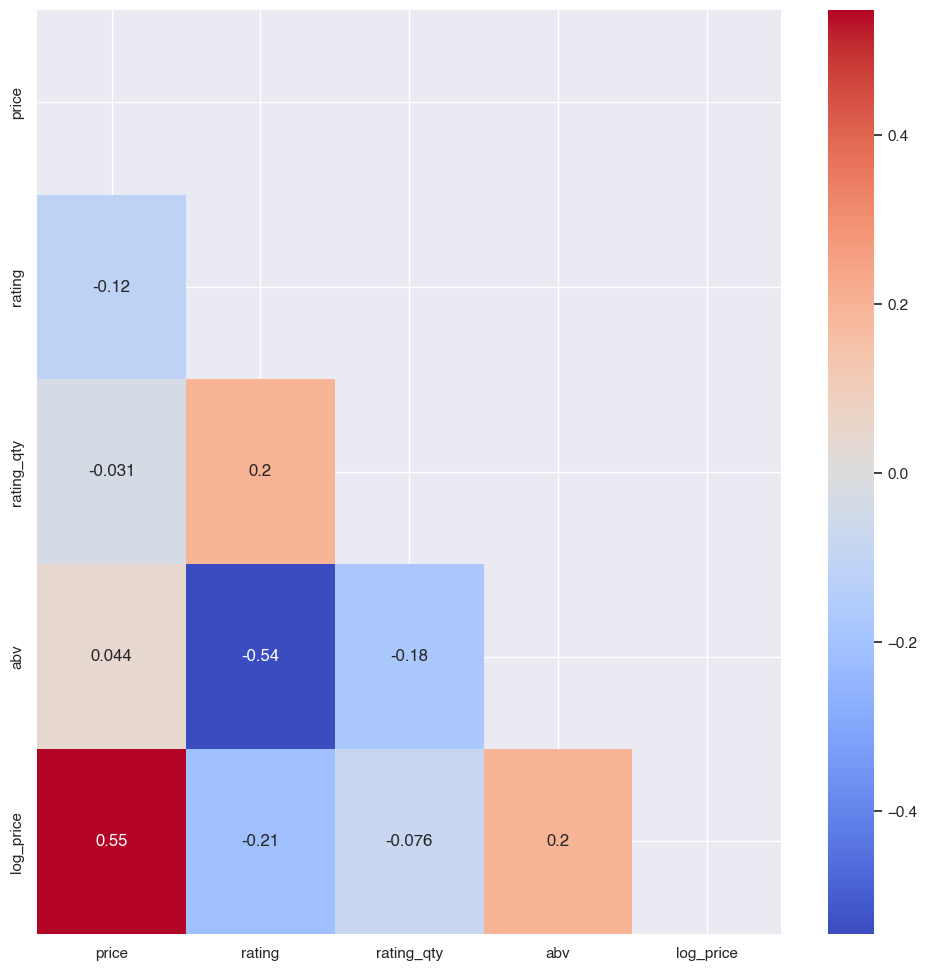

In [ ]:
numeric = df.drop(columns = ['name', 'region', 'country', 'vintage', 'producer', 'wine_variety',
       'grape_variety','reviewed_by','from_vivino'])

plt.figure(figsize=(12, 12))

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(numeric.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(numeric.corr(), mask = mask, annot=True, cmap='coolwarm');

# Price

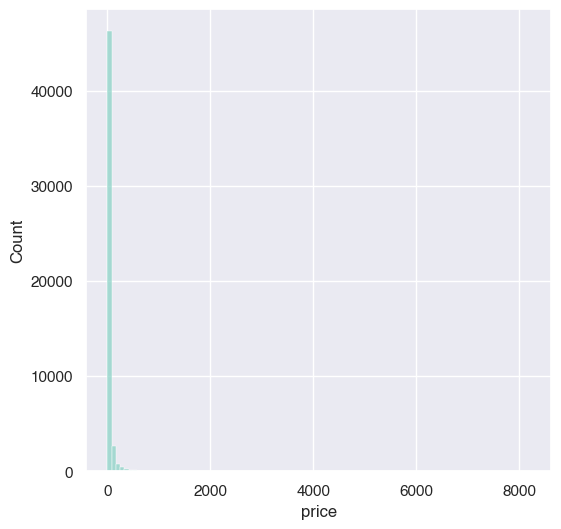

In [ ]:
plt.figure(figsize=(6, 6))
sns.histplot(df['price'], bins=100)  # kde=False turns off the kernel density estimate plot overlay
plt.show();

# Categoricals

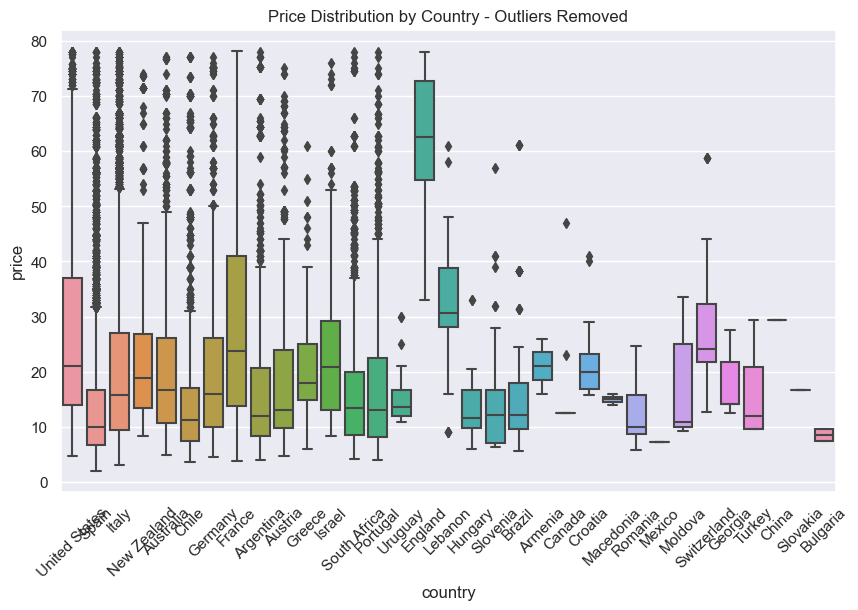

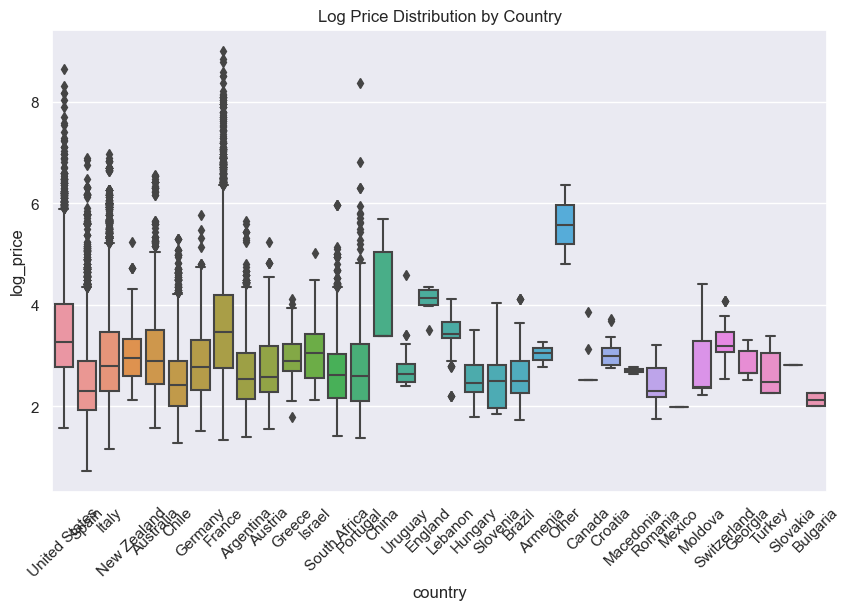

In [ ]:
# Box plot for 'country' vs 'price'
plt.figure(figsize=(10, 6)) 
sns.boxplot(x='country', y='price', data=df_IQR_price)
plt.xticks(rotation=45) # Rotate x labels for readability
plt.title('Price Distribution by Country - Outliers Removed')
plt.show()

# Box plot for 'country' vs 'log_price'
plt.figure(figsize=(10, 6)) 
sns.boxplot(x='country', y='log_price', data=df)
plt.xticks(rotation=45) 
plt.title('Log Price Distribution by Country')
plt.show()

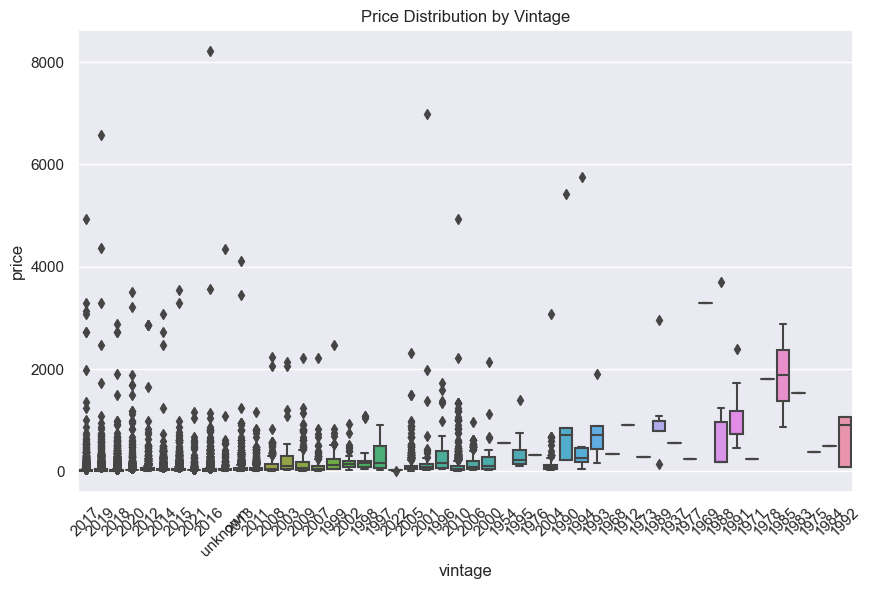

In [ ]:
# Box plot for 'vintage' vs 'price'
plt.figure(figsize=(10, 6))
sns.boxplot(x='vintage', y='price', data=df)
plt.xticks(rotation=45) # Rotate x labels for better readability
plt.title('Price Distribution by Vintage')
plt.show()

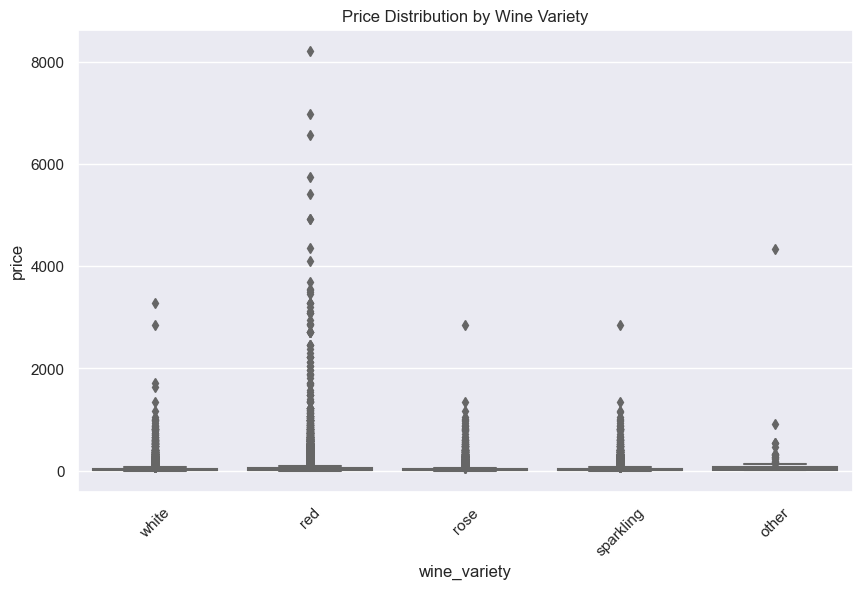

In [ ]:
# Box plot for 'wine_variety' vs 'price'
plt.figure(figsize=(10, 6))
sns.boxplot(x='wine_variety', y='price', data=df)
plt.xticks(rotation=45) # Rotate x labels for better readability
plt.title('Price Distribution by Wine Variety')
plt.show()

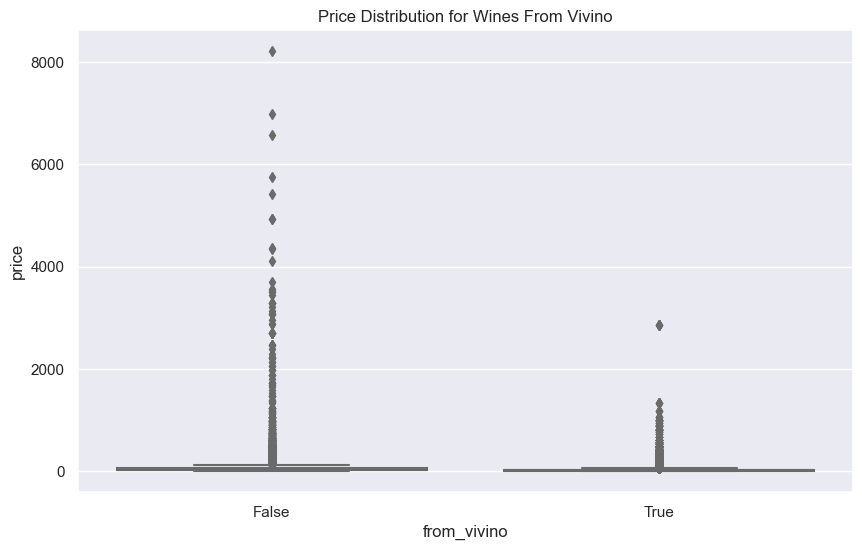

In [ ]:
# Box plot for 'from_vivino' (bool) vs 'price'
plt.figure(figsize=(10, 6))
sns.boxplot(x='from_vivino', y='price', data=df)
# No need to rotate x labels here as 'from_vivino' is a boolean variable
plt.title('Price Distribution for Wines From Vivino')
plt.show()